In [1]:
# see more styles and js code (linked at the bottom) at https://www.tylerxhobbs.com/words/flow-fields

In [2]:
from vfield import render_flow_field
import torch
import matplotlib.pyplot as plt
from PIL import Image

vfield = torch.load('../data/vectorfield.pt')

grid = vfield['grid']
displacement=vfield['displacement']

100%|██████████| 1000/1000 [00:03<00:00, 284.48it/s]



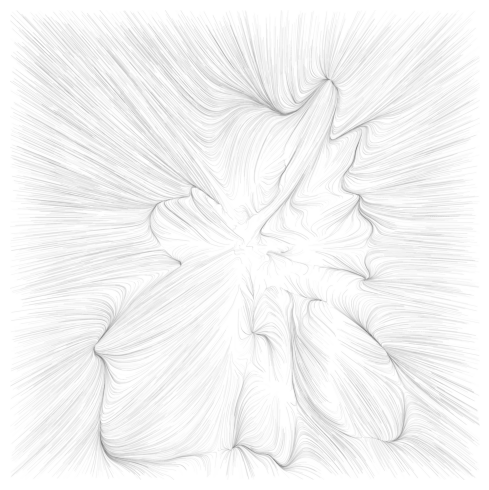

In [3]:
ff_img = render_flow_field(
    grid, displacement,
    W=2800, H=2800,
    particles=10_000,
    steps=1000,
    step_size=0.0001,
    bg_color=(255, 255, 255),
    trace_color=(0, 0, 0),
    random_colors=True,
    antialias=True,
    aa_factor=4
)

plt.figure(figsize=(15, 5))
plt.imshow(ff_img, origin='lower')
plt.axis('off')
plt.tight_layout()
plt.show()

ff_img = ff_img.transpose(Image.Transpose.FLIP_TOP_BOTTOM)
ff_img.save('../flow-field.jpg', quality=95)
ff_img.show()